# Penalized Linear Regression for Climate Temperature Prediction

This notebook implements penalized linear regression models (Ridge, Lasso, and ElasticNet) to predict average temperature based on climate-related features.

## Overview
- **Goal**: Predict `avg_temperature` using climate variables
- **Models**: Ridge, Lasso, and ElasticNet regression
- **Approach**: Use cross-validation with pipelines to tune hyperparameters while avoiding data leakage
- **Metrics**: R² (coefficient of determination), MSE (Mean Squared Error), RMSE, MAE

## Setup and Imports


In [122]:
# libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Scikit-learn
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.pipeline import Pipeline

# Settings
import warnings
warnings.filterwarnings('ignore')
np.random.seed(42)

# Create output directory for penalized regression results
OUTPUT_DIR = '../output/penalizedlinreg-outputs'
os.makedirs(OUTPUT_DIR, exist_ok=True)


## Load Training Data



In [123]:
# Load training data
X_train = pd.read_csv('../data/train_set_X.csv')
y_train = pd.read_csv('../data/train_set_y.csv').squeeze()  # Convert to Series

print(f"Training set size: {len(X_train)} samples")
print(f"\nFeatures ({X_train.shape[1]}):")
print(X_train.columns.tolist())
print(f"\nTarget: {y_train.name}")


Training set size: 800 samples

Features (7):
['co2_emissions', 'sea_level', 'rainfall', 'population', 'renewable_energy_pct', 'extreme_weather_events', 'forest_area_pct']

Target: avg_temperature




### Models We'll Compare:
1. **Ridge Regression (L2)**: Shrinks coefficients but keeps all features
2. **Lasso Regression (L1)**: Can shrink coefficients to exactly zero (feature selection)
3. **ElasticNet**: Combines L1 and L2 penalties



In [124]:
# Define cross-validation strategy
# Using 5-fold CV with shuffling for robust evaluation
cv = KFold(n_splits=5, shuffle=True, random_state=42)

print("Cross-validation strategy: 5-fold CV with shuffling")
print("Random state: 42 (for reproducibility)")


Cross-validation strategy: 5-fold CV with shuffling
Random state: 42 (for reproducibility)


## Ridge Regression (L2 Penalty)


In [125]:
# Create Ridge pipeline with StandardScaler
ridge_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge', Ridge(random_state=42))
])

# Define hyperparameter grid
# Testing a wide range of alpha values (log scale)
ridge_param_grid = {
    'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
}

# Perform GridSearchCV
ridge_grid_search = GridSearchCV(
    ridge_pipeline,
    ridge_param_grid,
    cv=cv,
    scoring='r2',  # R² score (higher is better)
    return_train_score=True,
    n_jobs=-1
)

# Fit the grid search
ridge_grid_search.fit(X_train, y_train)

print("Ridge Regression - Grid Search Complete")
print(f"Best alpha: {ridge_grid_search.best_params_['ridge__alpha']}")
print(f"Best CV R²: {ridge_grid_search.best_score_:.4f}")


Ridge Regression - Grid Search Complete
Best alpha: 1000
Best CV R²: -0.0169


## Lasso Regression (L1 Penalty)

In [126]:
# Create Lasso pipeline
lasso_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('lasso', Lasso(random_state=42, max_iter=10000))
])

# Define hyperparameter grid
lasso_param_grid = {
    'lasso__alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
}

# Perform GridSearchCV
lasso_grid_search = GridSearchCV(
    lasso_pipeline,
    lasso_param_grid,
    cv=cv,
    scoring='r2',  # R² score (higher is better)
    return_train_score=True,
    n_jobs=-1
)

# Fit the grid search
lasso_grid_search.fit(X_train, y_train)

print("Lasso Regression - Grid Search Complete")
print(f"Best alpha: {lasso_grid_search.best_params_['lasso__alpha']}")
print(f"Best CV R²: {lasso_grid_search.best_score_:.4f}")


Lasso Regression - Grid Search Complete
Best alpha: 1
Best CV R²: -0.0172


In [127]:
# Examine Lasso coefficients (feature selection)
best_lasso = lasso_grid_search.best_estimator_
lasso_coefs = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': best_lasso.named_steps['lasso'].coef_
}).sort_values('Coefficient', key=abs, ascending=False)

print("Lasso Feature Coefficients (Best Model):")
print("-" * 40)
for _, row in lasso_coefs.iterrows():
    status = "KEPT" if row['Coefficient'] != 0 else "DROPPED"
    print(f"{row['Feature']:30s}: {row['Coefficient']:8.4f} ({status})")

print(f"\nFeatures retained: {(lasso_coefs['Coefficient'] != 0).sum()} / {len(lasso_coefs)}")


Lasso Feature Coefficients (Best Model):
----------------------------------------
co2_emissions                 :   0.0000 (DROPPED)
sea_level                     :   0.0000 (DROPPED)
rainfall                      :   0.0000 (DROPPED)
population                    :  -0.0000 (DROPPED)
renewable_energy_pct          :  -0.0000 (DROPPED)
extreme_weather_events        :   0.0000 (DROPPED)
forest_area_pct               :  -0.0000 (DROPPED)

Features retained: 0 / 7


## ElasticNet Regression (L1 + L2 Penalty)


In [128]:
# Create ElasticNet pipeline
elasticnet_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('elasticnet', ElasticNet(random_state=42, max_iter=10000))
])

# Define hyperparameter grid (2D search: alpha and l1_ratio)
elasticnet_param_grid = {
    'elasticnet__alpha': [0.001, 0.01, 0.1, 1, 10, 100],
    'elasticnet__l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]
}

# Perform GridSearchCV
elasticnet_grid_search = GridSearchCV(
    elasticnet_pipeline,
    elasticnet_param_grid,
    cv=cv,
    scoring='r2',  # R² score (higher is better)
    return_train_score=True,
    n_jobs=-1
)

# Fit the grid search
elasticnet_grid_search.fit(X_train, y_train)

print("ElasticNet Regression - Grid Search Complete")
print(f"Best alpha: {elasticnet_grid_search.best_params_['elasticnet__alpha']}")
print(f"Best l1_ratio: {elasticnet_grid_search.best_params_['elasticnet__l1_ratio']}")
print(f"Best CV R²: {elasticnet_grid_search.best_score_:.4f}")


ElasticNet Regression - Grid Search Complete
Best alpha: 1
Best l1_ratio: 0.3
Best CV R²: -0.0165


## Model Comparison

Now we compare all three penalized regression models using multiple metrics computed via cross-validation.


In [129]:
# Create simple R² comparison table from GridSearchCV results
comparison_df = pd.DataFrame({
    'Model': ['Ridge', 'Lasso', 'ElasticNet'],
    'Best Alpha': [
        ridge_grid_search.best_params_['ridge__alpha'],
        lasso_grid_search.best_params_['lasso__alpha'],
        elasticnet_grid_search.best_params_['elasticnet__alpha']
    ],
    'CV R² Score': [
        ridge_grid_search.best_score_,
        lasso_grid_search.best_score_,
        elasticnet_grid_search.best_score_
    ]
})
comparison_df = comparison_df.set_index('Model')

print("PENALIZED LINEAR REGRESSION - CV R² COMPARISON")
display(comparison_df.round(4))


PENALIZED LINEAR REGRESSION - CV R² COMPARISON


,Best Alpha,CV R² Score
Model,,
Ridge,1000,-0.0169
Lasso,1,-0.0172
ElasticNet,1,-0.0165


## Best Model Selection

Based on the cross-validation results, we select the best performing penalized regression model.


In [130]:
# Select best model based on highest R²
best_model_name = comparison_df['CV R² Score'].idxmax()
best_r2 = comparison_df.loc[best_model_name, 'CV R² Score']

# Get the corresponding grid search object
model_mapping = {
    'Ridge': ridge_grid_search,
    'Lasso': lasso_grid_search,
    'ElasticNet': elasticnet_grid_search
}

best_grid_search = model_mapping[best_model_name]
best_model = best_grid_search.best_estimator_

print("BEST PENALIZED REGRESSION MODEL")
print(f"\nModel: {best_model_name}")
print(f"\nOptimal Hyperparameters:")
for param, value in best_grid_search.best_params_.items():
    print(f"  - {param.split('__')[1]}: {value}")
print(f"\nCross-Validation R² Score: {best_r2:.4f}")


BEST PENALIZED REGRESSION MODEL

Model: ElasticNet

Optimal Hyperparameters:
  - alpha: 1
  - l1_ratio: 0.3

Cross-Validation R² Score: -0.0165


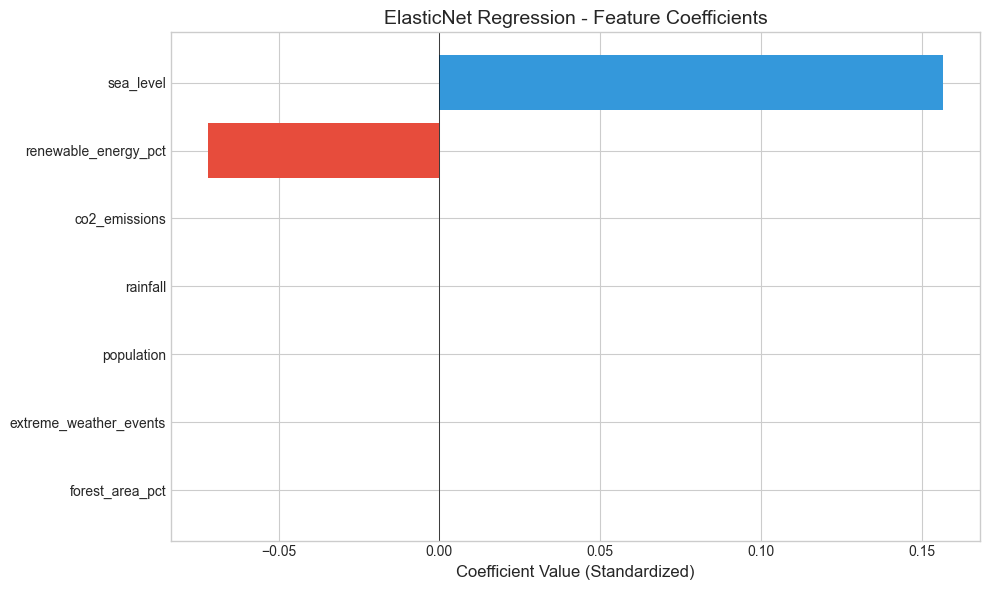


Figure saved to ../output/penalizedlinreg-outputs/best_model_coefficients.png

Coefficient Interpretation (standardized features):
  sea_level: +0.1567 (1 SD increase → temp increases)
  renewable_energy_pct: -0.0720 (1 SD increase → temp decreases)
  co2_emissions: +0.0000 (1 SD increase → temp decreases)
  rainfall: +0.0000 (1 SD increase → temp decreases)
  population: -0.0000 (1 SD increase → temp decreases)
  extreme_weather_events: +0.0000 (1 SD increase → temp decreases)
  forest_area_pct: -0.0000 (1 SD increase → temp decreases)


In [131]:
# Display coefficients of the best model
# Get the regressor from the pipeline
regressor_name = best_model_name.lower()
regressor = best_model.named_steps[regressor_name]

coef_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': regressor.coef_
}).sort_values('Coefficient', key=abs, ascending=False)

# Plot coefficients
fig, ax = plt.subplots(figsize=(10, 6))
colors = ['#e74c3c' if c < 0 else '#3498db' for c in coef_df['Coefficient']]
bars = ax.barh(coef_df['Feature'], coef_df['Coefficient'], color=colors)
ax.axvline(x=0, color='black', linewidth=0.5)
ax.set_xlabel('Coefficient Value (Standardized)', fontsize=12)
ax.set_title(f'{best_model_name} Regression - Feature Coefficients', fontsize=14)
ax.invert_yaxis()
plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/best_model_coefficients.png', dpi=150)
plt.show()

print(f"\nFigure saved to {OUTPUT_DIR}/best_model_coefficients.png")
print("\nCoefficient Interpretation (standardized features):")
for _, row in coef_df.iterrows():
    direction = "increases" if row['Coefficient'] > 0 else "decreases"
    print(f"  {row['Feature']}: {row['Coefficient']:+.4f} (1 SD increase → temp {direction})")


In [132]:
# Final summary table with all hyperparameters tested
print("COMPLETE HYPERPARAMETER SUMMARY")

print("\nRIDGE REGRESSION")
print(f"   Alpha values tested: {ridge_param_grid['ridge__alpha']}")
print(f"   Best alpha: {ridge_grid_search.best_params_['ridge__alpha']}")

print("\nLASSO REGRESSION")  
print(f"   Alpha values tested: {lasso_param_grid['lasso__alpha']}")
print(f"   Best alpha: {lasso_grid_search.best_params_['lasso__alpha']}")

print("\nELASTICNET REGRESSION")
print(f"   Alpha values tested: {elasticnet_param_grid['elasticnet__alpha']}")
print(f"   L1_ratio values tested: {elasticnet_param_grid['elasticnet__l1_ratio']}")
print(f"   Best alpha: {elasticnet_grid_search.best_params_['elasticnet__alpha']}")
print(f"   Best l1_ratio: {elasticnet_grid_search.best_params_['elasticnet__l1_ratio']}")

print("\nFINAL CV R² RESULTS")
display(comparison_df.round(4))

print(f"\nBest Penalized Regression Model: {best_model_name}")
print(f"CV R² Score: {best_r2:.4f}")


COMPLETE HYPERPARAMETER SUMMARY

RIDGE REGRESSION
   Alpha values tested: [0.001, 0.01, 0.1, 1, 10, 100, 1000]
   Best alpha: 1000

LASSO REGRESSION
   Alpha values tested: [0.001, 0.01, 0.1, 1, 10, 100, 1000]
   Best alpha: 1

ELASTICNET REGRESSION
   Alpha values tested: [0.001, 0.01, 0.1, 1, 10, 100]
   L1_ratio values tested: [0.1, 0.3, 0.5, 0.7, 0.9]
   Best alpha: 1
   Best l1_ratio: 0.3

FINAL CV R² RESULTS


,Best Alpha,CV R² Score
Model,,
Ridge,1000,-0.0169
Lasso,1,-0.0172
ElasticNet,1,-0.0165



Best Penalized Regression Model: ElasticNet
CV R² Score: -0.0165


In [133]:
# Save CV results to CSV
results_path = f'{OUTPUT_DIR}/cv_results_summary.csv'
comparison_df.to_csv(results_path)
print(f"CV results saved to: {results_path}")


CV results saved to: ../output/penalizedlinreg-outputs/cv_results_summary.csv
